In [149]:
%matplotlib inline 
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GMM 
from scipy.spatial.distance import hamming, euclidean
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [73]:
## import data for scenes (starting with 5,000 features)
V = pd.read_csv('VectorizedFeatures/AllComplied/AllScene_Features_Vectorize.txt',sep=',',header = None)

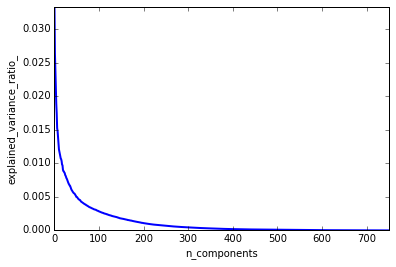

In [74]:
## Extract principal components , looking at variance explained of n components

# Using PCA
X = V
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

# Plot the PCA spectrum
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()


In [144]:
## Trying 300 components
n = 100
pca = PCA(n)
pca.fit(X)
X_pca = pca.transform(X)


In [145]:
### function to fit KMeans, GMM
def getKM(X, k):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=10000, n_init=30)
    km.fit(X)
    return km

def getGMM(X, k):
    gmm = GMM(n_components=k, n_init=30, covariance_type='full')
    gmm.fit(X)
    return gmm


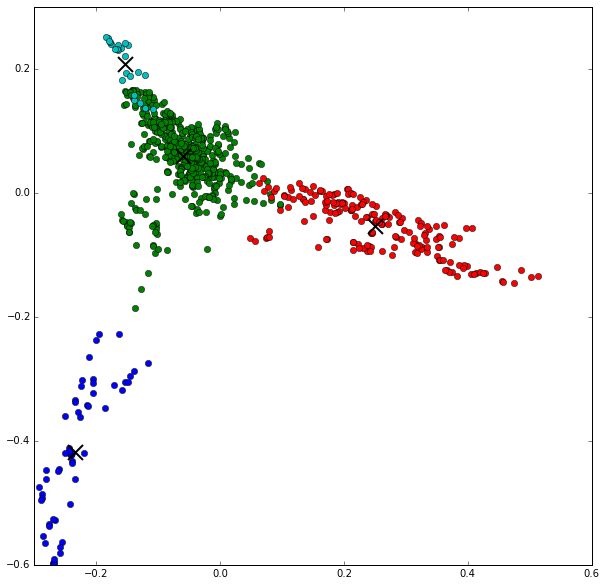

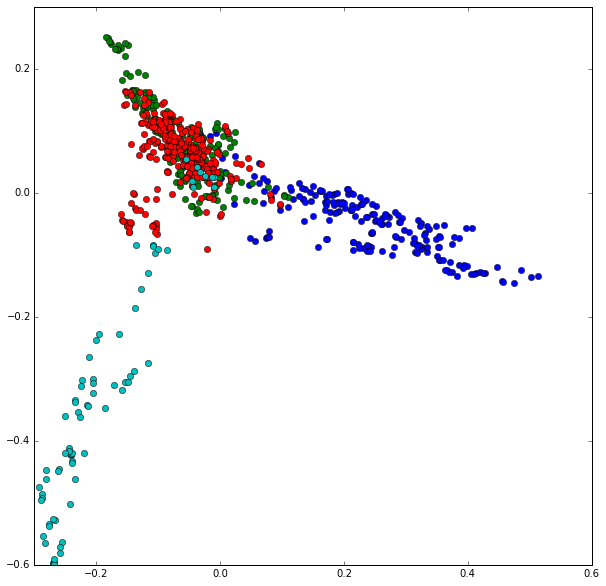

In [146]:
### fit K-Means cluster
true_k = 4
km = getKM(X_pca, true_k)
klabels = km.labels_
kcentroids = km.cluster_centers_

## plot K-Means
plt.figure(figsize=(10, 10))
for i in range(true_k):
    # plot data points
    dplt = X_pca[np.where(klabels==i)]
    plt.plot(dplt[:,0],dplt[:,1],'o')
    
    # plot centroids
    lines = plt.plot(kcentroids[i,0],kcentroids[i,1],'kx')
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)
plt.show()


### fit GMM with covariance_type = full 
gmm = getGMM(X_pca, true_k)
glabels = gmm.predict(X_pca)
gmeans = gmm.means_
gcovar = gmm.covars_

## plot GMM
plt.figure(figsize=(10, 10))
for i in range(true_k):
    # plot data points
    dplt = X_pca[np.where(glabels==i)]
    plt.plot(dplt[:,0],dplt[:,1],'o')

plt.show()

In [147]:
## Silhouette calculation & plot
## Adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import matplotlib.cm as cm

## function to generate list of silhouettes
def findSilh(km, X):
    k = km.n_clusters
    clusters = []
    points = {}
    for i in range(k):
        clusters.append(km.cluster_centers_[i])
        ps = X[np.where(km.labels_==i)]
        points[i] = [np.array(p) for p in ps]
    all_silhs = []

    # loop all clusters
    for c in range(k):
        cluster = clusters[c]
        other_clusters = clusters[:c] + clusters[c+1:]
        silhs = [] #create empty list for silhouettes

        # loop all points in clusters
        for i in range(len(points[c])):
            point = points[c][i]
            others = points[c][:i] + points[c][i+1:]

            # get a(i) -- find average hamming distance between a(i) and other q points in the same cluster
            sum = 0
            for q in others:
                sum += euclidean(point, q)
            a = sum / len(others)

            # get b(i) -- find lowest average hamming distance between a(i) to q points in other clusters
            b_list = []
            for d in other_clusters: #find average hamming distance to each other cluster
                sum = 0
                for q in d:
                    sum += euclidean(point, q)
                avg_dist = sum / len(d)
                b_list.append(avg_dist) #add to list
            b = min(b_list) #get the lowest one

            # calculate silhouette
            silh = (b - a) / max(a, b)
            silhs.append(silh) #add to list
        silhs.sort() #sort
        all_silhs.append(silhs) #add to list of all clusters
    return all_silhs

## function to plot
def plotSilh(s):
    with plt.style.context('ggplot'):
        fig = plt.figure()
        n = len(s)
        y_lower = 10
        silh_avg = np.mean([x for list in s for x in list])
        for i in range(n): 
            cls = s[i]
            size = len(cls)
            y_upper = y_lower + size
            color = cm.spectral(float(i) / n)
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cls, facecolor=color, edgecolor=color, alpha=0.7)
            plt.text(-0.05, y_lower + 0.5 * size, str(i))
            y_lower = y_upper + 10

        plt.title('Silhouette plot K = ' + str(n))
        plt.xlabel('Silhouette Coefficient Values')
        plt.ylabel('Cluster Label')
        plt.axvline(x=silh_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.show()
    return "At K = " + str(n) + ", Average Silhouette Score = " + str(silh_avg)


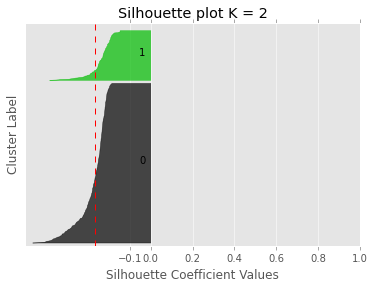

At K = 2, Average Silhouette Score = -0.265380325718


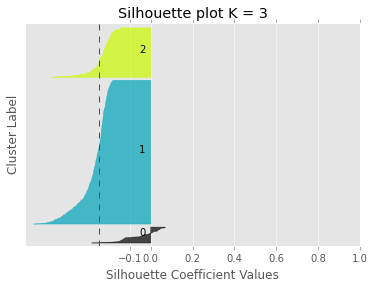

At K = 3, Average Silhouette Score = -0.247100464595


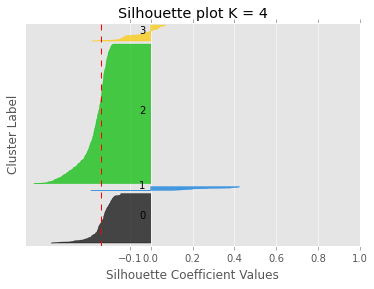

At K = 4, Average Silhouette Score = -0.236773550051


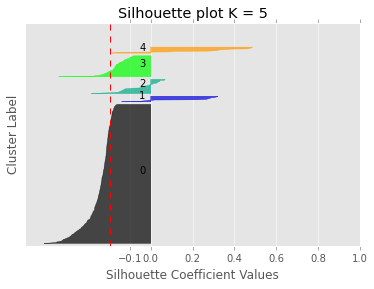

At K = 5, Average Silhouette Score = -0.193854197086


In [148]:
### Evaluate KMeans cluster performance of each K choice (2 to 5) using Silhouette plot
n_k = [2, 3, 4, 5]
for k in n_k:
    km = getKM(X_pca, k)
    print(plotSilh(findSilh(km, X_pca)))
